# DNN and Learning Rate sweep  on Synthetic Time Series Dataset from Week 1:


Coursera Colab Link: https://colab.research.google.com/github/lmoroney/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%202%20Lesson%203.ipynb

TF Dataset: https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch

np.newaxis: https://medium.com/@ian.dzindo01/what-is-numpy-newaxis-and-when-to-use-it-8cb61c7ed6ae

Keras Callbacks: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

2.2.0-rc2


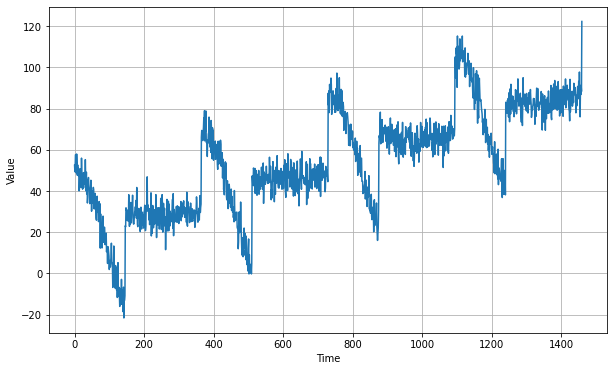

In [0]:
# Creating a synthetic Time Series:

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

In [0]:
# Spliting the data into Training and Validation sets:

time_split = 1000

time_train = time[:time_split]
x_train = series[:time_split]

time_val = time[time_split:]
x_val = series[time_split:]

In [0]:
# Parameters for preparing the dataset ready for ML:

window_size = 20  # window_size is the number of features!
batch_size = 32
shuffle_buffer_size = 1000

# DNN Model with fixed learning rate:

In [0]:
# Function to window + capping + flattening + splitting + batching the dataset:

def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size) :
  dataset = tf.data.Dataset.from_tensor_slices(series)                                # create a tf dataset. we import the time series into tensorflow dataset using from_tensor_slices
  dataset = dataset.window(size=window_size + 1, shift = 1, drop_remainder=True)      # slice the dataset by windows. we add +1 into window_size as the additional one will be used as label!!!
  dataset = dataset.flat_map(lambda window: window.batch(window_size+1))              # flatten the data out to be easier to work with. we flatten the data into chuncks of the size of window_size+1
  dataset = dataset.shuffle(shuffle_buffer_size)                                      # once flattened it is easy to shuffle the order of the windows. it picks large dataset by groups of shuffle_buffer_size and then takes random samples. This speeds up the random shuffling in large datasets.
  dataset = dataset.map(lambda window: (window[:-1], window[-1:]))                    # splitting the data into features and labels (last one) using map and lambda function. this is stored in tuples.
  dataset = dataset.batch(batch_size).prefetch(1)                                     # the split dataset is batched in batches of the specified size.

  return dataset

In [0]:
# Creating the Model:

# preparing the dataset by calling the function defined above:
# !!! we use the training dataset here!
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Setting up the DNN model:
model = tf.keras.models.Sequential( )
model.add(tf.keras.layers.Dense(10, activation='relu', input_shape=[window_size]))
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1))   # the liner regression does not need activation!!!

model.summary()

model.compile(optimizer= tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9), loss='mse', metrics=['accuracy','mae','mse'])  # we use stochastic gradient descent as optimizer and 'mean squared error' as loss function. Classic linear regression.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                210       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Training the model:

history =  model.fit(dataset, epochs=100, verbose=1)

Epoch 1/100
31/31 [==============================] - 0s 3ms/step - loss: 201.9509 - accuracy: 0.0000e+00
Epoch 2/100
31/31 [==============================] - 0s 3ms/step - loss: 115.0255 - accuracy: 0.0000e+00
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 106.0115 - accuracy: 0.0000e+00
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 95.4280 - accuracy: 0.0000e+00
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 91.5361 - accuracy: 0.0000e+00
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 87.5251 - accuracy: 0.0000e+00
Epoch 7/100
31/31 [==============================] - 0s 3ms/step - loss: 84.7686 - accuracy: 0.0000e+00
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 82.4224 - accuracy: 0.0000e+00
Epoch 9/100
31/31 [==============================] - 0s 3ms/step - loss: 78.4848 - accuracy: 0.0000e+00
Epoch 10/100
31/31 [==============================] - 0s 3ms/

1441
[array([[45.156296]], dtype=float32), array([[47.856537]], dtype=float32)]


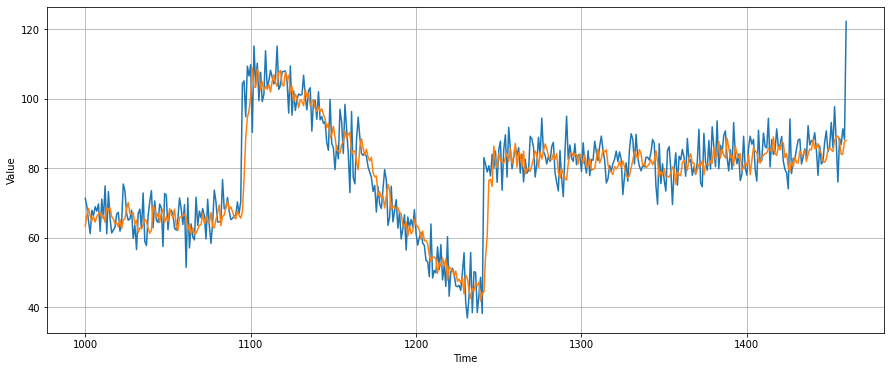

In [0]:
# Prediction of all elements of the validation set:

# Calculating predictions by picking up slices of window_size each time:
forecast = []
for time in range(len(series)-window_size) :
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))  # np.newaxis converts 1D into 2D arrays.

print(len(forecast))
print(forecast[:2])

# Getting the predictions of the validation set only
forecast = forecast[time_split-window_size:]  # !!! Careful here!!! -> the predictions index are shifted by window_size
results = np.array(forecast)[:,0,0]  

plt.figure(figsize=(15,6))

plot_series(time_val, x_val)
plot_series(time_val, results)
plt.show()


In [0]:
# Prediction statistical Metrics:

print(tf.keras.metrics.mean_squared_error(x_val, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_val, results).numpy())

45.756702
4.896029


# DNN with learning rate sweep:

In [0]:
# Creating the Model:

# preparing the dataset by calling the function defined above:
# !!! we use the training dataset here!
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Setting up the DNN model:
model = tf.keras.models.Sequential( )
model.add(tf.keras.layers.Dense(10, activation='relu', input_shape=[window_size]))
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1))   # the liner regression does not need activation!!!

model.summary()

model.compile(optimizer= tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9), loss='mse', metrics=['accuracy','mae','mse'])  # we use stochastic gradient descent as optimizer and 'mean squared error' as loss function. Classic linear regression.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Callback to adapt the Learning Rate:

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20)
)



# Training the model:

history =  model.fit(dataset, epochs=100, callbacks=[lr_schedule], verbose=1)

Epoch 1/100
31/31 [==============================] - 0s 2ms/step - loss: 14679.0283 - accuracy: 0.0000e+00 - lr: 1.0000e-08
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 7321.4941 - accuracy: 0.0000e+00 - lr: 1.1220e-08
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 3625.1516 - accuracy: 0.0000e+00 - lr: 1.2589e-08
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 1778.6921 - accuracy: 0.0000e+00 - lr: 1.4125e-08
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 813.5265 - accuracy: 0.0000e+00 - lr: 1.5849e-08
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 332.2513 - accuracy: 0.0000e+00 - lr: 1.7783e-08
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 143.2848 - accuracy: 0.0000e+00 - lr: 1.9953e-08
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 84.4184 - accuracy: 0.0000e+00 - lr: 2.2387e-08
Epoch 9/100
31/31 [=

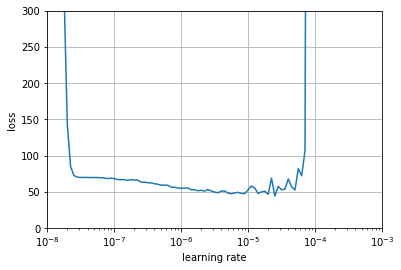

In [0]:
# Plotting the loss history vs learning rate:

lrs = 1e-8 * (10 ** (np.arange(100)/20))
plt.semilogx(lrs, history.history['loss'])
plt.axis([1e-8, 1e-3, 0, 300])
plt.xlabel('learning rate')
plt.ylabel('loss')
plt.grid()
plt.show()

# Re-training the DNN with the best Learning Rate

In [0]:
# Creating the Model:

# preparing the dataset by calling the function defined above:
# !!! we use the training dataset here!
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Setting up the DNN model:
model = tf.keras.models.Sequential( )
model.add(tf.keras.layers.Dense(10, activation='relu', input_shape=[window_size]))
model.add(tf.keras.layers.Dense(10, activation='relu'))
model.add(tf.keras.layers.Dense(1))   # the liner regression does not need activation!!!

model.summary()

model.compile(optimizer= tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9), loss='mse', metrics=['accuracy','mae','mse'])  # we use stochastic gradient descent as optimizer and 'mean squared error' as loss function. Classic linear regression.


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_7 (Dense)              (None, 10)                110       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 11        
Total params: 331
Trainable params: 331
Non-trainable params: 0
_________________________________________________________________


In [0]:
history =  model.fit(dataset, epochs=500, verbose=1)

Epoch 1/500
31/31 [==============================] - 0s 3ms/step - loss: 403.5493 - accuracy: 0.0000e+00
Epoch 2/500
31/31 [==============================] - 0s 3ms/step - loss: 70.9678 - accuracy: 0.0000e+00
Epoch 3/500
31/31 [==============================] - 0s 2ms/step - loss: 58.9623 - accuracy: 0.0000e+00
Epoch 4/500
31/31 [==============================] - 0s 2ms/step - loss: 55.7137 - accuracy: 0.0000e+00
Epoch 5/500
31/31 [==============================] - 0s 3ms/step - loss: 54.3761 - accuracy: 0.0000e+00
Epoch 6/500
31/31 [==============================] - 0s 3ms/step - loss: 53.8419 - accuracy: 0.0000e+00
Epoch 7/500
31/31 [==============================] - 0s 2ms/step - loss: 50.5128 - accuracy: 0.0000e+00
Epoch 8/500
31/31 [==============================] - 0s 3ms/step - loss: 51.1978 - accuracy: 0.0000e+00
Epoch 9/500
31/31 [==============================] - 0s 3ms/step - loss: 49.8457 - accuracy: 0.0000e+00
Epoch 10/500
31/31 [==============================] - 0s 2ms/st

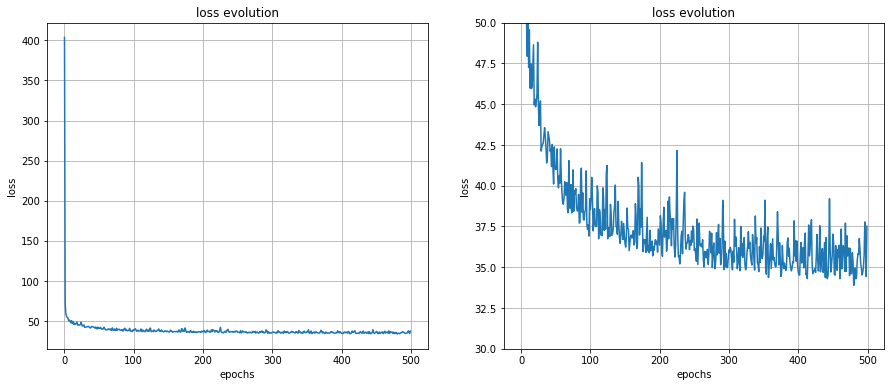

In [0]:
loss = history.history['loss']

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.plot(loss, label='training loss')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('loss evolution')

plt.subplot(1,2,2)
plt.plot(loss, label='training loss')
plt.grid()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim((30, 50))
plt.title('loss evolution')

plt.show()

1441
[array([[44.641254]], dtype=float32), array([[46.245113]], dtype=float32)]


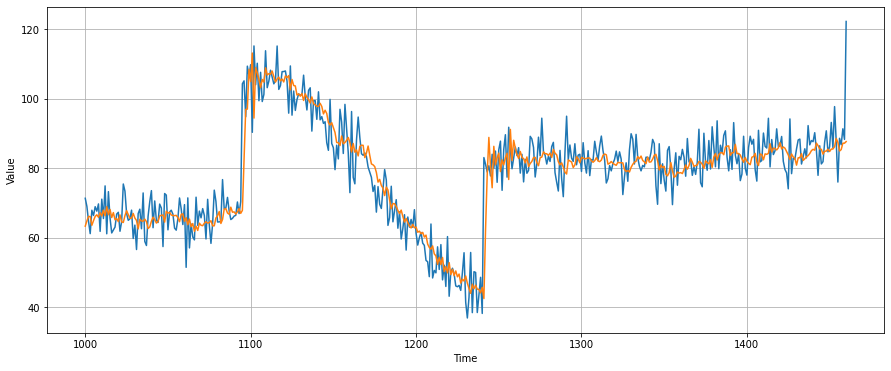

In [0]:
# Prediction of all elements of the validation set:

# Calculating predictions by picking up slices of window_size each time:
forecast = []
for time in range(len(series)-window_size) :
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))  # np.newaxis converts 1D into 2D arrays.

print(len(forecast))
print(forecast[:2])

# Getting the predictions of the validation set only
forecast = forecast[time_split-window_size:]  # !!! Careful here!!! -> the predictions index are shifted by window_size
results = np.array(forecast)[:,0,0]  

plt.figure(figsize=(15,6))

plot_series(time_val, x_val)
plot_series(time_val, results)
plt.show()


In [0]:
# Prediction statistical Metrics:

print(tf.keras.metrics.mean_squared_error(x_val, results).numpy())
print(tf.keras.metrics.mean_absolute_error(x_val, results).numpy())

41.98826
4.723638
